# Exploring the Yelp Data Set

In [1]:
import pandas as pd
import csv

In [2]:
pd.__version__

'0.23.3'

# Businesses JSON file

Contains 174,000 businesses with various location data.

In [3]:
businesses = pd.read_json('./data/business.json', lines=True, dtype={})
businesses.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


In [4]:
businesses.shape

(174567, 15)

Business data set is 15MB:

In [5]:
businesses.memory_usage()

Index                80
address         1396536
attributes      1396536
business_id     1396536
categories      1396536
city            1396536
hours           1396536
is_open         1396536
latitude        1396536
longitude       1396536
name            1396536
neighborhood    1396536
postal_code     1396536
review_count    1396536
stars           1396536
state           1396536
dtype: int64

# Reviews JSON file

In [6]:
reader = pd.read_json('./data/review.json', lines=True, chunksize=1000)
num_chunks = 0
last_chunk = None
for chunk in reader:
    num_chunks += 1
    if num_chunks >= 1:
        last_chunk = chunk
        break
last_chunk.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


Review data set should be about 357 MB:

In [7]:
# Chunk size # num chunks
(8000 * 9) * 5200 / 1024 / 1024

357.0556640625

# Join text reviews with location of businesses

In [8]:
%%time

# Define batch size, all 5.2M reviews won't fit in memory
batch_size = 100000

# Number of chunks to read in this call
chunk_limit = 10

# Subset columns to location data, ids, and name only
businesses = businesses[['business_id', 'city', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'state']]

with open('./data/reviews.csv', 'w+') as f:
    f.close() # overwrite file to empty

# Read JSON file from Yelp
reader = pd.read_json('./data/review.json', lines=True, chunksize=batch_size)

# # The dataframe we'll work with
reviews = pd.DataFrame(columns=[
                          'business_id',
                          'review_id',
                          'text',
                          'user_id',
                          'city',
                          'latitude',
                          'longitude', 
                          'name',
                          'neighborhood',
                          'postal_code',
                          'state',
                      ])

# Iterate through batches
chunks = 0
for chunk in reader:

    # Subset review columns and join to location data from business file
    chunk = chunk[['business_id', 'review_id', 'text', 'user_id']]
    chunk = chunk.merge(businesses, on='business_id', how='left')
    reviews = reviews.append(chunk, ignore_index=True)

    chunks += 1
    if chunks >= chunk_limit:
        break

print(reviews.shape)

(1000000, 11)
CPU times: user 33.2 s, sys: 4.39 s, total: 37.6 s
Wall time: 37.6 s


# Exploring location data

In [9]:
# first, explore the distribution of reviews by state in the data set
counts = reviews.groupby(['state'])['review_id'].count()
counts = counts.sort_values(ascending=False)
counts[counts > 1000]

state
NV     346940
AZ     312538
ON     116444
NC      58217
OH      47314
PA      43119
QC      29073
WI      20726
EDH      8816
BW       6733
IL       6731
SC       1949
Name: review_id, dtype: int64

This gives us 14 states which we will can use as a proxy for dialects (eliminating any states with less than 1000 reviews). These states are not evenly geographically distributed, and are probably not a great representation of dialect. In future work, we'll explore different representations of dialect mentioned above

- NV     346935 # Nevada
- AZ     307215 # Arizona
- ON     121478 # Ontario
- NC      59643 # North Carolina
- OH      46006 # Ohio
- PA      44420 # Pennsylvania
- QC      27922 # Quebec
- WI      21666 # Wisconsin
- EDH      8346 # Edinburgh, Scotland
- IL       6967 # Illinois
- BW       6058 # Baden-Württemberg, Germany
- SC       2042 # South Carolina

Let's remove any non Canadian-American countries:

In [10]:
reviews = reviews[(reviews['latitude'] > 20) & (reviews['latitude'] < 70) 
                  & (reviews['longitude'] > -140) & (reviews['longitude'] < -50)]
reviews.shape

(983194, 11)

# Constructing dialect labels

There are a few ways we might construct labels for our dialect classification task:

1. look for a different dataset that includes American English dialects
2. perform clustering to discover regional clusters of similar vocabulary/syntax.
3. choose arbitrary regions as dialects (west coast, northeast, south), and manually apply the dialect to each review
4. use the country, state, or city of the review to represent the dialect.

For our initial attemps, we'll first explore option #3, and #4.

For #4, the `state` variable provides our lables. For, #3, we'll first add a regional label for each review:

In [9]:
def compute_region(row):
    if row['state'] == 'ON' or row['state'] == 'QC':
        return 'canada'
    if row['latitude'] > 43 and row['longitude'] < -108:
        return 'pnw'
    if row['latitude'] < 43 and row['longitude'] < -108:
        return 'west'
    if row['latitude'] < 38 and row['longitude'] > -108:
        return 'south'
    if row['latitude'] > 38 and row['longitude'] > -108 and row['longitude'] < -84:
        return 'midwest'
    if row['latitude'] > 38 and row['longitude'] > -84:
        return 'northeast'

In [ ]:
reviews['region'] = reviews.apply(compute_region, axis=1)

Let's inspect the distribution of reviews by region - it looks like there are 5 regions with a substantial set of reviews.

In [12]:
reg_counts = reviews.groupby(['region'])['review_id'].count()
reg_counts = reg_counts.sort_values(ascending=False)
print(reg_counts)

region
west         659499
canada       145510
northeast     90451
south         60235
midwest       27497
pnw               2
Name: review_id, dtype: int64


Let's now plot the reviews by region to get a sense of how our reviews are geographically distributed:

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

/home/d_l_strockis/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/d_l_strockis/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,'Map of reviews in North America')

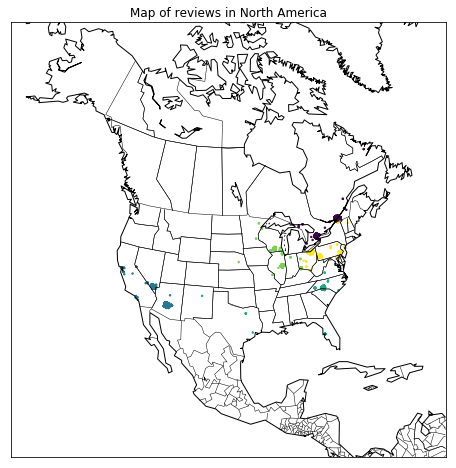

In [14]:
lon = reviews.loc[:,'longitude'].values
lat = reviews.loc[:,'latitude'].values
colors = reviews.loc[:, 'region'].map({
    'canada': 0,
    'pnw': 1,
    'west': 2,
    'south': 3,
    'midwest': 4,
    'northeast': 5,
})

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', resolution='c', width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.drawcoastlines()
m.drawcountries()
m.drawstates()

m.scatter(lon, lat, latlon=True, s=2, c=colors)

plt.title('Map of reviews in North America')


# Exploring & cleaning text reviews

Because different models we apply to our task might require different text cleaning steps to be taken, we choose to not implement text cleaning here, but in the forthcoming notebooks.

# Write pre-processed data to disk

In [10]:
%%time

import re
def remove_sep_char(text):
    return re.sub(r"\|", " ", text)

# Define batch size, all 5.2M reviews won't fit in memory
batch_size = 100000

# Subset columns to location data, ids, and name only
businesses = businesses[['business_id', 'city', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'state']]

with open('./data/reviews.csv', 'w+') as f:
    f.close() # overwrite file to empty

# Read JSON file from Yelp
reader = pd.read_json('./data/review.json', lines=True, chunksize=batch_size)

# Write joined chunks to CSV file
with open('./data/reviews.csv', 'a') as f:
    
    num_batches = 0
    # Iterate through batches
    for reviews in reader:

        # Subset review columns and join to location data from business file
        reviews = reviews[['business_id', 'review_id', 'text', 'user_id']]
        reviews = reviews.merge(businesses, on='business_id', how='left')
        
        # Remove any non US & Canada reviews
        reviews = reviews[(reviews['latitude'] > 20) & (reviews['latitude'] < 70) 
                  & (reviews['longitude'] > -140) & (reviews['longitude'] < -50)]

        # Add a region column to the data set based on latitude & longitude
        reviews['region'] = reviews.apply(compute_region, axis=1)
        
        ## remove any pipe characters, which will be used as seperators in files
        reviews['text'] = reviews['text'].map(lambda x: remove_sep_char(x))
        
        reviews.to_csv(
            f, 
            header=False, 
            encoding='utf-8', 
            sep='|',
            quoting=csv.QUOTE_MINIMAL,
            columns=[
              'business_id',
              'review_id',
              'user_id',
              'latitude',
              'longitude',
              'region',
              'name',
              'postal_code',
              'city',
              'state',
              'neighborhood',
              'text',
          ]
        )
        
        num_batches += 1
        
        print('Wrote {0} lines'.format(str(num_batches*batch_size)))

Wrote 100000 lines
Wrote 200000 lines
Wrote 300000 lines
Wrote 400000 lines
Wrote 500000 lines
Wrote 600000 lines
Wrote 700000 lines
Wrote 800000 lines
Wrote 900000 lines
Wrote 1000000 lines
Wrote 1100000 lines
Wrote 1200000 lines
Wrote 1300000 lines
Wrote 1400000 lines
Wrote 1500000 lines
Wrote 1600000 lines
Wrote 1700000 lines
Wrote 1800000 lines
Wrote 1900000 lines
Wrote 2000000 lines
Wrote 2100000 lines
Wrote 2200000 lines
Wrote 2300000 lines
Wrote 2400000 lines
Wrote 2500000 lines
Wrote 2600000 lines
Wrote 2700000 lines
Wrote 2800000 lines
Wrote 2900000 lines
Wrote 3000000 lines
Wrote 3100000 lines
Wrote 3200000 lines
Wrote 3300000 lines
Wrote 3400000 lines
Wrote 3500000 lines
Wrote 3600000 lines
Wrote 3700000 lines
Wrote 3800000 lines
Wrote 3900000 lines
Wrote 4000000 lines
Wrote 4100000 lines
Wrote 4200000 lines
Wrote 4300000 lines
Wrote 4400000 lines
Wrote 4500000 lines
Wrote 4600000 lines
Wrote 4700000 lines
Wrote 4800000 lines
Wrote 4900000 lines
Wrote 5000000 lines
Wrote 510